
# Investigation into the Citibike data

### IDEA:
Customers are less likely than Subscribers to choose biking _for commuting_
### NULL HYPOTHESIS:
The ratio of subscribers biking on weekends over subscribers biking on weekdays is _the same_ or _higher_ than the ratio of customers biking on weekends over customers biking on weekdays.
### ALTERNATIVE HYPOTHESIS:
The ratio of subscribers biking on weekends over subscribers biking on weekdays is _less_ than the ratio of customers biking on weekends over customers biking on weekdays.

# _$H_0$_ : $\frac{S{\mathrm{weekend}}}{S{\mathrm{weekdays}}} => \frac{C{\mathrm{weekend}}}{C{\mathrm{weekdays}}}$
# _$H_1$_ : $\frac{S{\mathrm{weekend}}}{S{\mathrm{weekdays}}} < \frac{C{\mathrm{weekend}}}{C{\mathrm{weekdays}}}$

<=>

# _$H_0$_ : $\frac{S{\mathrm{weekend}}}{S{\mathrm{weekdays}}} - \frac{C{\mathrm{weekend}}}{C{\mathrm{weekdays}}} => 0 $
# _$H_1$_ : $\frac{S{\mathrm{weekend}}}{S{\mathrm{weekdays}}} - \frac{C{\mathrm{weekend}}}{C{\mathrm{weekdays}}} < 0 $


Significance level:  $\alpha=0.05$



In [1]:
from __future__  import print_function, division
import pylab as pl
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from scipy import stats

%pylab inline

if os.getenv ('PUIDATA') is None:
    print ("Must set env variable PUIDATA")


Populating the interactive namespace from numpy and matplotlib


In [2]:
#function to download the data
def getCitiBikeCSV(datestring):
    print ("Downloading", datestring)
    #check that it is not already there
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        if os.path.isfile(datestring + "-citibike-tripdata.csv"):
            #if in the current dir -> move it
            if os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA")):
                print ("Error moving file!, Please check!")
        #otherwise start looking for the zip file
        else:
            if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip"):
                if not os.path.isfile(datestring + "-citibike-tripdata.zip"):
                    os.system("curl -O https://s3.amazonaws.com/tripdata/" + datestring + "-citibike-tripdata.zip")
                os.system("mv " + datestring + "-citibike-tripdata.zip " + os.getenv("PUIDATA"))
            #unzip the csv 
            os.system("unzip " + os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip")
            os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA"))
    #final check:
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        print ("WARNING!!! something is wrong: the file is not there!")

    else:
        print ("file in place, you can continue")

In [3]:
#function to calculate Chi Square statistic
def evalChisq(values):
    '''Evaluates the chi sq from a contingency value
    Arguments:
    values: 2x2 array or list, the contingengy table
    '''
    if not (len(values.shape) == 2 and values.shape == (2,2)):
        print ("must pass a 2D array")
        return -1
    values = np.array(values)
    E = np.empty_like(values)
    for j in range(len(values[0])):
        for i in range(2):
            
            E[i][j] = ((values[i,:].sum() * values[:,j].sum()) / 
                        (values).sum())
    return ((values - E)**2 / E).sum()

### We are using two months of Citibike dataset to check the robustness of our results. In order to investigate whether the test holds in the winter and summer of 2016, January and July data were studied. 


In [4]:
#reading data from citibike csv file from January 2016, i.e. 201601-citibike-tripdata.csv
jan2016 = '201601'
getCitiBikeCSV(jan2016)

file in place, you can continue


In [5]:
#dataframe where the content of the 201601-citibike-tripdata.csv file is stored
df = pd.read_csv(os.getenv("PUIDATA") + "/" + jan2016 + '-citibike-tripdata.csv')
df['date'] = pd.to_datetime(df['starttime'])
df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,date
0,923,1/1/2016 00:00:41,1/1/2016 00:16:04,268,Howard St & Centre St,40.719105,-73.999733,3002,South End Ave & Liberty St,40.711512,-74.015756,22285,Subscriber,1958.0,1,2016-01-01 00:00:41
1,379,1/1/2016 00:00:45,1/1/2016 00:07:04,476,E 31 St & 3 Ave,40.743943,-73.979661,498,Broadway & W 32 St,40.748549,-73.988084,17827,Subscriber,1969.0,1,2016-01-01 00:00:45
2,589,1/1/2016 00:00:48,1/1/2016 00:10:37,489,10 Ave & W 28 St,40.750664,-74.001768,284,Greenwich Ave & 8 Ave,40.739017,-74.002638,21997,Subscriber,1982.0,2,2016-01-01 00:00:48
3,889,1/1/2016 00:01:06,1/1/2016 00:15:56,268,Howard St & Centre St,40.719105,-73.999733,3002,South End Ave & Liberty St,40.711512,-74.015756,22794,Subscriber,1961.0,2,2016-01-01 00:01:06
4,1480,1/1/2016 00:01:12,1/1/2016 00:25:52,2006,Central Park S & 6 Ave,40.765909,-73.976342,2006,Central Park S & 6 Ave,40.765909,-73.976342,14562,Subscriber,1952.0,1,2016-01-01 00:01:12


In [6]:
#we only need the user type, date, and time of the beginning of each trip
df.drop(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid',
       'birth year', 'gender'], axis=1, inplace=True)

df.head()

,usertype,date
0,Subscriber,2016-01-01 00:00:41
1,Subscriber,2016-01-01 00:00:45
2,Subscriber,2016-01-01 00:00:48
3,Subscriber,2016-01-01 00:01:06
4,Subscriber,2016-01-01 00:01:12


In [7]:
#reading data from citibike csv file from July 2016, i.e. 201607-citibike-tripdata.csv
jul2016 = '201607'
getCitiBikeCSV(jul2016)

file in place, you can continue


In [12]:
#dataframe where the content of the 201607-citibike-tripdata.csv file is stored
df2 = pd.read_csv(os.getenv("PUIDATA") + "/" + jul2016 + '-citibike-tripdata.csv')
df2['date'] = pd.to_datetime(df2['starttime'])
df2.head()                  

,usertype,date
0,Subscriber,2016-01-01 00:00:41
1,Subscriber,2016-01-01 00:00:45
2,Subscriber,2016-01-01 00:00:48
3,Subscriber,2016-01-01 00:01:06
4,Subscriber,2016-01-01 00:01:12


In [13]:
#we only need the user type, date, and time of the beginning of each trip
df2.drop(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid',
       'birth year', 'gender'], axis=1, inplace=True)
df2.head()

,usertype,date
0,Customer,2016-07-01 00:00:02
1,Subscriber,2016-07-01 00:00:18
2,Subscriber,2016-07-01 00:00:19
3,Customer,2016-07-01 00:00:24
4,Customer,2016-07-01 00:00:31


### We are dealing with categorical data, i.e. subscribers and customers. Let us plot the number of trips per week day

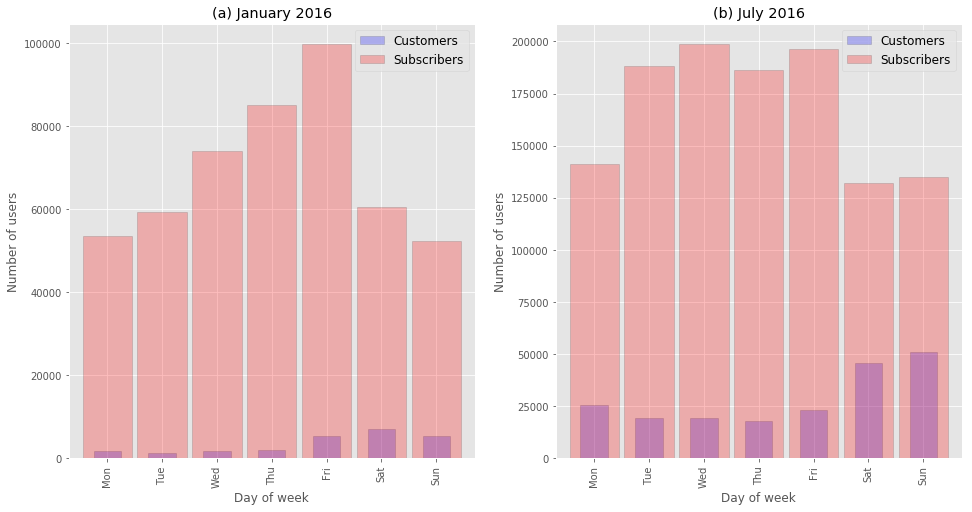

In [240]:
norm_c = 1
norm_s = 1

counts_c = df.date[df.usertype == "Customer"].groupby([df.date.dt.weekday]).count()
counts_s = df.date[df.usertype == "Subscriber"].groupby([df.date.dt.weekday]).count()
counts_c2 = df2.date[df2.usertype == "Customer"].groupby([df2.date.dt.weekday]).count()
counts_s2 = df2.date[df2.usertype == "Subscriber"].groupby([df2.date.dt.weekday]).count()

plt.figure(figsize(16, 8))

ax1 = plt.subplot(1,2,1)
ax1 = ((counts_c) / norm_c).plot(kind="bar", alpha=0.25, label='Customer', 
                                 color = 'blue', edgecolor='black')
ax1 = ((counts_s) / norm_s).plot(kind="bar", alpha=0.25, label='Subscriber', 
                                 color = 'red', edgecolor='black', width=0.9)

ax1.set_title('(a) January 2016')
ax1.xaxis.set_ticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax1.set_xlabel('Day of week')
ax1.set_ylabel('Number of users')
plt.legend(['Customers','Subscribers'], fontsize=12)

ax2 = plt.subplot(1,2,2)
ax2 = ((counts_c2) / norm_c).plot(kind="bar", alpha=0.25, label='Customer', 
                                  color = 'blue', edgecolor='black',)
ax2 = ((counts_s2) / norm_s).plot(kind="bar", alpha=0.25, label='Subscriber', 
                                  color = 'red', edgecolor='black', width=0.9)

ax2.set_title('(b) July 2016')
ax2.xaxis.set_ticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax2.set_xlabel('Day of week')
ax2.set_ylabel('Number of users')
plt.legend(['Customers','Subscribers'], fontsize=12)

plt.show()

<center><h3>Fig 1. Distribution of Citi Bike users by type of plan (Customers = 24-hour pass or 3-day pass users; Subscribers = Annual Members) during two winter and summer months, absolute counts</center></h3>

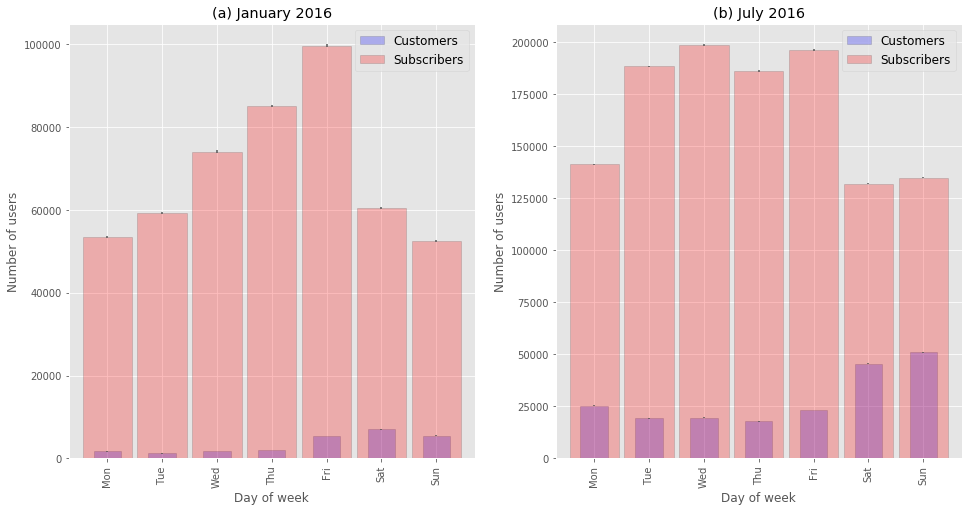

In [241]:
error_c = np.sqrt(counts_c)
error_s = np.sqrt(counts_s)
error_c2 = np.sqrt(counts_c2)
error_s2 = np.sqrt(counts_s2)


plt.figure(figsize(16, 8))


ax1 = plt.subplot(1,2,1)

ax1 = ((counts_c) / norm_c).plot(kind="bar", alpha=0.25, label='Customer', color = 'blue', edgecolor='black', 
                                 yerr=[((error_c) / norm_c, (error_c) / norm_c)])
ax1 = ((counts_s) / norm_s).plot(kind="bar", alpha=0.25, label='Subscriber', color = 'red', edgecolor='black', 
                                 yerr=[((error_s) / norm_s, (error_s) / norm_s)], width=0.9)

ax1.set_title('(a) January 2016')
ax1.xaxis.set_ticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax1.set_xlabel('Day of week')
ax1.set_ylabel('Number of users')
plt.legend(['Customers','Subscribers'], fontsize=12)

ax2 = plt.subplot(1,2,2)
ax2 = ((counts_c2) / norm_c).plot(kind="bar", alpha=0.25, label='Customer', color = 'blue', edgecolor='black',
                                 yerr=[((error_c2) / norm_c, (error_c2) / norm_c)])
ax2 = ((counts_s2) / norm_s).plot(kind="bar", alpha=0.25, label='Subscriber', color = 'red', edgecolor='black',
                                 yerr=[((error_s2) / norm_s, (error_s2) / norm_s)], width=0.9)

ax2.set_title('(b) July 2016')
ax2.xaxis.set_ticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax2.set_xlabel('Day of week')
ax2.set_ylabel('Number of users')
plt.legend(['Customers','Subscribers'], fontsize=12)

plt.show()

<center><h3>Fig 2. Distribution of Citi Bike users by type of plan (Customers = 24-hour pass or 3-day pass users; Subscribers = Annual Members) during two winter and summer months, absolute counts with statistical errors</center></h3>

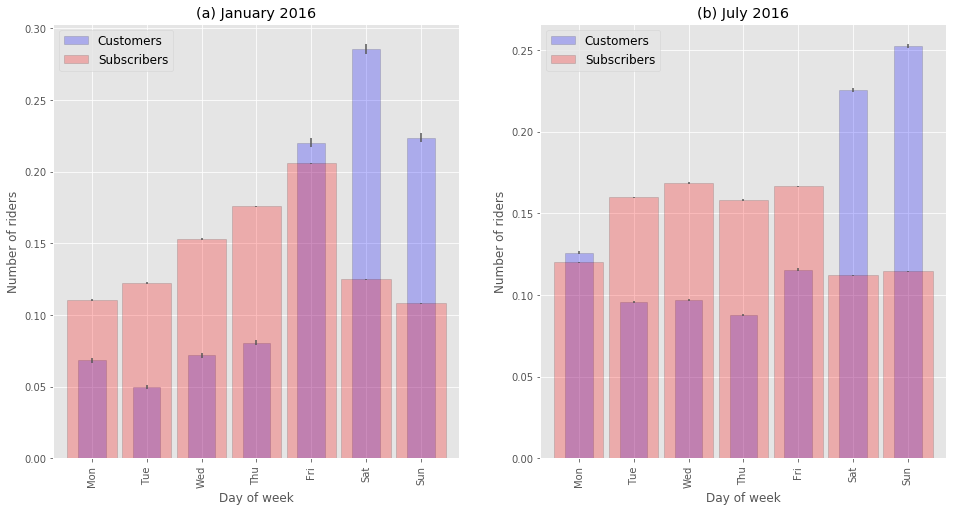

In [242]:
norm_c = counts_c.sum()
norm_s = counts_s.sum()
norm_c2 = counts_c2.sum()
norm_s2 = counts_s2.sum()

plt.figure(figsize(16, 8))

ax1 = plt.subplot(1,2,1)
ax1 = ((counts_c) / norm_c).plot(kind="bar", alpha=0.25, label='Customer', color = 'blue', edgecolor='black',
                                 yerr=[((error_c) / norm_c, (error_c) / norm_c)])
ax1 = ((counts_s) / norm_s).plot(kind="bar", alpha=0.25, label='Subscriber', color = 'red', edgecolor='black',
                                 yerr=[((error_s) / norm_s, (error_s) / norm_s)], width = 0.9)

ax1.set_title('(a) January 2016')
ax1.xaxis.set_ticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax1.set_xlabel('Day of week')
ax1.set_ylabel('Number of riders')
plt.legend(['Customers','Subscribers'], fontsize=12)


ax2 = plt.subplot(1,2,2)
ax2 = ((counts_c2) / norm_c2).plot(kind="bar", alpha=0.25, label='Customer', color = 'blue', edgecolor='black',
                                 yerr=[((error_c2) / norm_c2, (error_c2) / norm_c2)])
ax2 = ((counts_s2) / norm_s2).plot(kind="bar", alpha=0.25, label='Subscriber', color = 'red', edgecolor='black',
                                 yerr=[((error_s2) / norm_s2, (error_s2) / norm_s2)], width = 0.9)

ax2.set_title('(b) July 2016')
ax2.xaxis.set_ticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax2.set_xlabel('Day of week')
ax2.set_ylabel('Number of riders')
plt.legend(['Customers','Subscribers'], fontsize=12)

plt.show()


<center><h3>Fig 3. Distribution of Citi Bike users by type of plan (Customers = 24-hour pass or 3-day pass users; Subscribers = Annual Members) during two winter and summer months, normalized</center></h3>

We observe that proportions are significantly different. 
Is the difference in the sample large enough to infer that there is a difference in population?

### Setting up the Chi-Square test of proportions

Chi-Square statistics tests a number against the distribution of the following quantity:

$$\chi^2 = \Sigma \frac{(observation - expectation)^2}{expectation}$$


If we talk about sample fractions  that is: 

$$\chi^2 = \Sigma \frac{(f_{observed} - f_{expectated})^2}{f_{expected}}$$

This quantity is distributed according to a chi square distribution.
Therefore when we get the $\chi^2$ statistics, one can compare it to the full chisq distribution and see how far in the tail it is.


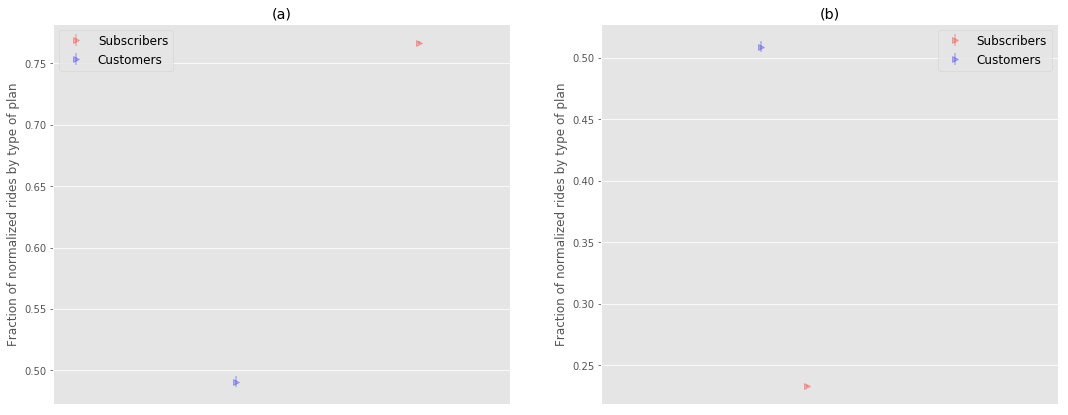

In [243]:
week_c = sum(counts_c[:-2]) * 1.0 / norm_c  #fraction of customers riding on weekdays
weekend_c = sum(counts_c[-2:]) * 1.0 / norm_c  #fraction of customers riding on weekends
eweek_c = np.sqrt(sum(error_c[:-2]**2)) / norm_c  #error on fraction number of customers riding on weekdays
eweekend_c = np.sqrt(sum(error_c[-2:]**2)) / norm_c #error on fraction number of customers riding on weekends

week_s = sum(counts_s[:-2]) * 1.0 / norm_s
weekend_s = sum(counts_s[-2:]) * 1.0 / norm_s
eweek_s = np.sqrt(sum(error_s[:-2]**2)) / norm_s
eweekend_s = np.sqrt(sum(error_s[-2:]**2)) / norm_s

fig = pl.figure(figsize(18, 7))

ax1 = fig.add_subplot(121)
ax1.set_xticks([])
ax1.errorbar([0.4], [week_s], yerr=[eweek_s], fmt='>', alpha=0.25, label='Subscribers', color = 'red')
ax1.errorbar([0.2], [week_c], yerr=[eweek_c], fmt='>', alpha=0.25, label='Customers', color = 'blue')
ax1.set_xlim(0, 0.5)
ax1.set_title('(a)')
ax1.set_ylabel("Fraction of normalized rides by type of plan")
ax1.legend(fontsize=12)

ax2 = fig.add_subplot(122)
ax2.set_xticks([])
ax2.errorbar([0.4], [weekend_s], yerr=[eweekend_s], fmt='>', alpha=0.25, label='Subscribers', color = 'red')
ax2.errorbar([0.2], [weekend_c], yerr=[eweekend_c], fmt='>', alpha=0.25, label='Customers', color = 'blue')
ax2.set_xlim(0, 0.5)
ax2.set_title('(b)')
ax2.set_ylabel("Fraction of normalized rides by type of plan")
ax2.legend(fontsize=12)

pl.xlim(-0.5, 1.5)
print()

<center><h3>Fig 4. Fraction of Citi Bike users by type of plan (Customers = 24-hour pass or 3-day pass users; Subscribers = Annual Members) in January 2016 during (a) weekdays and (b) weekends</center></h3>

In [244]:
week_count_s = sum(counts_s[:-2]) * 1.0
weekend_count_s = sum(counts_s[-2:]) * 1.0

week_count_c= sum(counts_c[:-2]) * 1.0
weekend_count_c = sum(counts_c[-2:]) * 1.0

print('Sample size:')
print('Subscriber: week: {0:.0f}, weekend: {1:.0f}, total: {2:.0f}'\
      .format(week_count_s, weekend_count_s, week_count_s + weekend_count_s))
print('Customer: week: {0:.0f}, weekend: {1:.0f}, total: {2:.0f}'\
      .format(week_count_c, weekend_count_c, week_count_c + weekend_count_c))

Sample size:
Subscriber: week: 371928, weekend: 113007, total: 484935
Customer: week: 12050, weekend: 12493, total: 24543


In [245]:
print("Subrscriber: weekday:{0:.2f}, weekend:{1:.2f}, weekend error:{2:.4f}, weekend error:{3:.4f}"\
      .format(week_s, weekend_s, eweek_s, eweekend_s))
print("Customer: weekday:{0:.2f}, weekend:{1:.2f}, weekend error:{2:.4f}, weekend error:{3:.4f}"\
      .format(week_c, weekend_c, eweek_c, eweekend_c))

Subrscriber: weekday:0.77, weekend:0.23, weekend error:0.0013, weekend error:0.0007
Customer: weekday:0.49, weekend:0.51, weekend error:0.0045, weekend error:0.0046


In [246]:
values = np.array([[week_s* norm_s, weekend_s*norm_s],[week_c*norm_c, weekend_c*norm_c]])
print(values)

[[ 371928.  113007.]
 [  12050.   12493.]]


<h3><center> Table 1. Contingency table (type of plan/day of week) for January 2016 </center></h3>

|             |      Weekday      |     Weekend       | Total     |        
|-------------|-------------------|-------------------|-----------|
| Subscriber  | 0.77 * 1,178,219  | 0.23 * 1,178,219  | 484,935   |
| Customer    | 0.49 *   201,891  | 0.51 *   201,891  |   24,543  |
| Total       |     383,978       |      125,500      | 509478    |

In [247]:
chisq = evalChisq(values)
# degrees of freedom: Nvar - 1 
DOF = len(values) - 1
print ('chi sq statistics for user type ridership on weekdays vs weekends: '+
       'chisq = {:.3f}, DOF = {:d}'.format(chisq, DOF))

chi sq statistics for user type ridership on weekdays vs weekends: chisq = 9584.557, DOF = 1


In [248]:
chi_minalpha95 = 3.84
print ("The null hypothesis that the ratio of subscribers biking on weekends over subscribers biking on weekdays is the same " + 
       "or higher than the ratio of customers biking on weekends over customers biking on weekdays ")
if chisq > chi_minalpha95 :
    print ("can be rejected at alpha = 0.05")
else: 
    print ("cannot be rejected (p<0.05)")
print ("with a chi square statistics of {:.2f}".format(chisq))

The null hypothesis that the ratio of subscribers biking on weekends over subscribers biking on weekdays is the same or higher than the ratio of customers biking on weekends over customers biking on weekdays 
can be rejected at alpha = 0.05
with a chi square statistics of 9584.56


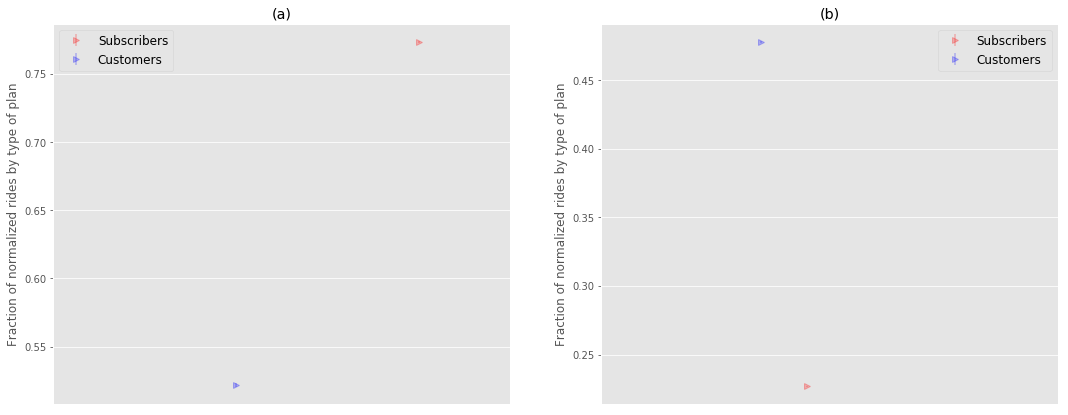

In [249]:
week_c2 = sum(counts_c2[:-2]) * 1.0 / norm_c2  #fraction of customers riding on weekdays
weekend_c2 = sum(counts_c2[-2:]) * 1.0 / norm_c2  #fraction of customers riding on weekends
eweek_c2 = np.sqrt(sum(error_c2[:-2]**2)) / norm_c2  #error on fraction number of customers riding on weekdays
eweekend_c2 = np.sqrt(sum(error_c[-2:]**2)) / norm_c2 #error on fraction number of customers riding on weekends

week_s2 = sum(counts_s2[:-2]) * 1.0 / norm_s2
weekend_s2 = sum(counts_s2[-2:]) * 1.0 / norm_s2
eweek_s2 = np.sqrt(sum(error_s2[:-2]**2)) / norm_s2
eweekend_s2 = np.sqrt(sum(error_s2[-2:]**2)) / norm_s2

fig = pl.figure(figsize(18, 7))

ax1 = fig.add_subplot(121)
ax1.set_xticks([])
ax1.errorbar([0.4], [week_s2], yerr=[eweek_s2], fmt='>', alpha=0.25, label='Subscribers', color = 'red')
ax1.errorbar([0.2], [week_c2], yerr=[eweek_c2], fmt='>', alpha=0.25, label='Customers', color = 'blue')
ax1.set_xlim(0, 0.5)
ax1.set_title('(a)')
ax1.set_ylabel("Fraction of normalized rides by type of plan")
ax1.legend(fontsize=12)

ax2 = fig.add_subplot(122)
ax2.set_xticks([])
ax2.errorbar([0.4], [weekend_s2], yerr=[eweekend_s2], fmt='>', alpha=0.25, label='Subscribers', color = 'red')
ax2.errorbar([0.2], [weekend_c2], yerr=[eweekend_c2], fmt='>', alpha=0.25, label='Customers', color = 'blue')
ax1.set_xlim(0, 0.5)
ax2.set_title('(b)')
ax2.set_ylabel("Fraction of normalized rides by type of plan")
ax2.legend(fontsize=12)

pl.xlim(-0.5, 1.5)
print()

<center><h3>Fig 5. Fraction of Citi Bike users by type of plan (Customers = 24-hour pass or 3-day pass users; Subscribers = Annual Members) in July 2016 during (a) weekdays and (b) weekends</center></h3>

In [250]:
week_count_s2 = sum(counts_s2[:-2]) * 1.0
weekend_count_s2 = sum(counts_s2[-2:]) * 1.0

week_count_c2 = sum(counts_c2[:-2]) * 1.0
weekend_count_c2 = sum(counts_c2[-2:]) * 1.0

print('Sample size:')
print('Subscriber: weekday: {0:.0f}, weekend: {1:.0f}, total: {2:.0f}'\
      .format(week_count_s2, weekend_count_s2, week_count_s2 + weekend_count_s2))
print('Customer: weekday: {0:.0f}, weekend: {1:.0f}, total: {2:.0f}'\
      .format(week_count_c2, weekend_count_c2, week_count_c2 + weekend_count_c2))

Sample size:
Subscriber: weekday: 911052, weekend: 267167, total: 1178219
Customer: weekday: 105396, weekend: 96495, total: 201891


In [251]:
print("Subrscriber: week:{0:.2f}, weekend:{1:.2f}, weekend error:{2:.4f}, weekend error:{3:.4f}"\
      .format(week_s2, weekend_s2, eweek_s2, eweekend_s2))
print("Customer: week:{0:.2f}, weekend:{1:.2f}, weekend error:{2:.4f}, weekend error:{3:.4f}"\
      .format(week_c2, weekend_c2, eweek_c2, eweekend_c2))

Subrscriber: week:0.77, weekend:0.23, weekend error:0.0008, weekend error:0.0004
Customer: week:0.52, weekend:0.48, weekend error:0.0016, weekend error:0.0006


In [252]:
sample_values2 = np.array([[week_s2 * sum(counts_s2), weekend_s2 * sum(counts_s2)],\
                            [week_c2 * sum(counts_c2), weekend_c2 * sum(counts_c2)]])
print(sample_values2)

[[ 911052.  267167.]
 [ 105396.   96495.]]


<h3><center> Table 2. Contingency table (type of plan/day of week) for July 2016 </center></h3>

|             |      Weekday     |      Weekend      |   Total   |        
|-------------|------------------|-------------------|-----------|
| Subscriber  | 0.77 * 1,178,219 | 0.23 * 1,178,219  | 1,178,219 |
| Customer    | 0.52 * 201,891   | 0.48 *   201,891  |   201,891 |
| Total       |     1,016,448    |      363,662      | 1,380,110 |

In [253]:
chisq2 = evalChisq(sample_values2)

In [254]:
# degrees of freedom: Nvar - 1 
DOF2 = len(sample_values2) - 1
print ('chi sq statistics for user type ridership on weekdays vs weekends: '+
       'chisq = {:.3f}, DOF = {:d}'.format(chisq2, DOF2))

chi sq statistics for user type ridership on weekdays vs weekends: chisq = 56042.334, DOF = 1


In [255]:
chi_minalpha95 = 3.84
print ("The null hypothesis that the ratio of subscribers biking on weekends over subscribers biking on weekdays is the same " + 
       "or higher than the ratio of customers biking on weekends over customers biking on weekdays ")
if chisq > chi_minalpha95 :
    print ("can be rejected at alpha = 0.05")
else: 
    print ("cannot be rejected (p<0.05)")
print ("with a chi square statistics of {:.2f}".format(chisq2))

The null hypothesis that the ratio of subscribers biking on weekends over subscribers biking on weekdays is the same or higher than the ratio of customers biking on weekends over customers biking on weekdays 
can be rejected at alpha = 0.05
with a chi square statistics of 56042.33
